In [1]:
import sys
sys.path.append('..')

import os
import numpy as np
import helpers as h
import cv2 as cv
from matplotlib import pyplot as plt
import random as rng
from skimage.morphology import convex_hull_image
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.draw import polygon

20


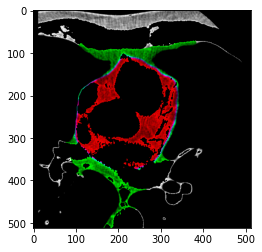

In [2]:
patients = h.listdir('data/input')
print(len(patients))
labelled_image = cv.imread('data/labelled/ACel/009.bmp')
plt.imshow(labelled_image[...,::-1])

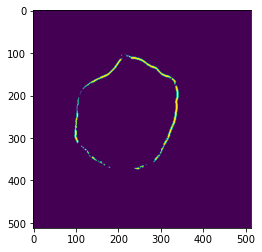

In [3]:
lab_cop = labelled_image.copy()
hsv = cv.cvtColor(lab_cop, cv.COLOR_BGR2HSV)
pericardium = cv.inRange(hsv, (80, 0, 1), (170, 255,255))
plt.imshow(pericardium)

In [6]:
def get_snake(iters):
    img = pericardium.copy()

    s = np.linspace(0, 2*np.pi, 400)
    r = pericardium.shape[0] // 2 + pericardium.shape[0] // 2 * np.sin(s)
    c = pericardium.shape[0] // 2 + pericardium.shape[0] // 2 * np.cos(s)
    init = np.array([r, c]).T

    snake = active_contour(gaussian(img, 3),
                           init, alpha=0.01, beta=1, gamma=0.001, max_iterations=iters)

    return snake

In [8]:
img = pericardium.copy()
images = [pericardium, img, img, img, img, img]
snakes = [get_snake(1), get_snake(100), get_snake(200), get_snake(300), get_snake(400)]

<ipython-input-6-a8244c8c53be>:9: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  snake = active_contour(gaussian(img, 3),


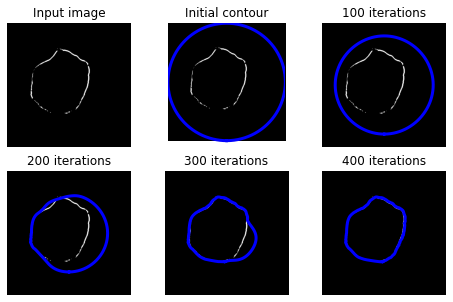

In [13]:
fig, ax = plt.subplots(2, len(images) // 2, figsize=(8, 5))
ax = ax.flatten()
for i in range(len(images)):
    ax[i].imshow(images[i], cmap="gray")
    ax[i].axis('off')
    if i > 0:
        ax[i].plot(snakes[i - 1][:, 0], snakes[i - 1][:, 1], '-b', lw=3)

ax[0].set_title("Input image")
ax[1].set_title("Initial contour")
ax[2].set_title("100 iterations")
ax[3].set_title("200 iterations")
ax[4].set_title("300 iterations")
ax[5].set_title("400 iterations")

plt.savefig('plots/active_contour.png', facecolor='white')
plt.show()

In [14]:
def simple_region_growing(img, seed, threshold=1, conn=4):
    """
    A (very) simple implementation of region growing.
    Extracts a region of the input image depending on a start position and a stop condition. 
    The input should be a single channel 8 bits image and the seed a pixel position (x, y).
    The threshold corresponds to the difference between outside pixel intensity and mean intensity of region.
    In case no new pixel is found, the growing stops. 
    The connectivity can be set to 4 or 8. 4-connectivity is taken by default, and 8-connectiviy requires most computations.
    Outputs a single channel 8 bits binary (0 or 255) image. Extracted region is highlighted in white.
    """

    try:
        dims = cv.GetSize(img)
    except TypeError:
        raise TypeError("(%s) img : IplImage expected!" % (sys._getframe().f_code.co_name))

    # img test
    if not(img.depth == cv.IPL_DEPTH_8U):
        raise TypeError("(%s) 8U image expected!" % (sys._getframe().f_code.co_name))
    elif not(img.nChannels is 1):
        raise TypeError("(%s) 1C image expected!" % (sys._getframe().f_code.co_name))
    # threshold tests
    if (not isinstance(threshold, int)) : 
        raise TypeError("(%s) Int expected!" % (sys._getframe().f_code.co_name))
    elif threshold < 0:
        raise ValueError("(%s) Positive value expected!" % (sys._getframe().f_code.co_name))
    # seed tests
    if not((isinstance(seed, tuple)) and (len(seed) is 2) ) : 
        raise TypeError("(%s) (x, y) variable expected!" % (sys._getframe().f_code.co_name))
    
    if (seed[0] or seed[1] ) < 0 :
        raise ValueError("(%s) Seed should have positive values!" % (sys._getframe().f_code.co_name))
    elif ((seed[0] > dims[0]) or (seed[1] > dims[1])):
        raise ValueError("(%s) Seed values greater than img size!" % (sys._getframe().f_code.co_name))
    
    # Connectivity tests
    if (not isinstance(conn, int)) : 
        raise TypeError("(%s) Int expected!" % (sys._getframe().f_code.co_name))
    if conn == 4:
        orient = [(1, 0), (0, 1), (-1, 0), (0, -1)] # 4 connectivity
    elif conn == 8:
        orient = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)] # 8 connectivity
    else:
        raise ValueError("(%s) Connectivity type not known (4 or 8 available)!" % (sys._getframe().f_code.co_name))

    reg = cv.CreateImage( dims, cv.IPL_DEPTH_8U, 1)
    cv.Zero(reg)

    #parameters
    mean_reg = float(img[seed[1], seed[0]])
    size = 1
    pix_area = dims[0]*dims[1]

    contour = [] # will be [ [[x1, y1], val1],..., [[xn, yn], valn] ]
    contour_val = []
    dist = 0

    cur_pix = [seed[0], seed[1]]

    #Spreading
    while(dist<threshold and size<pix_area):
    #adding pixels
        for j in range(len(orient)):
            #select new candidate
            temp_pix = [cur_pix[0] +orient[j][0], cur_pix[1] +orient[j][1]]

            #check if it belongs to the image
            is_in_img = dims[0]>temp_pix[0]>0 and dims[1]>temp_pix[1]>0 #returns boolean
            #candidate is taken if not already selected before
            if (is_in_img and (reg[temp_pix[1], temp_pix[0]]==0)):
                contour.append(temp_pix)
                contour_val.append(img[temp_pix[1], temp_pix[0]] )
                reg[temp_pix[1], temp_pix[0]] = 150
        #add the nearest pixel of the contour in it
        dist_list = [abs(i - mean_reg) for i in contour_val ]
        dist = min(dist_list)    #get min distance
        index = dist_list.index(min(dist_list)) #mean distance index
        size += 1 # updating region size
        reg[cur_pix[1], cur_pix[0]] = 255

        #updating mean MUST BE FLOAT
        mean_reg = (mean_reg*size + float(contour_val[index]))/(size+1)
        #updating seed
        cur_pix = contour[index]

        #removing pixel from neigborhood
        del contour[index]
        del contour_val[index]       

    return reg

<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-14-ea034338f22c>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  elif not(img.nChannels is 1):
<ipython-input-14-ea034338f22c>:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not((isinstance(seed, tuple)) and (len(seed) is 2) ) :


In [15]:
simple_region_growing(img, (250, 250))

AttributeError: module 'cv2' has no attribute 'GetSize'

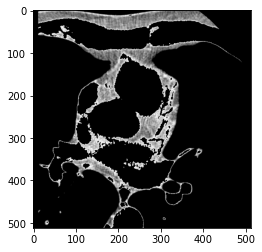

In [16]:
img = cv.imread('dataset_pericardium_manual/input/ACel/009.png')
plt.imshow(img)

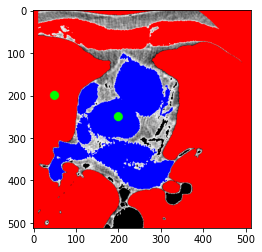

In [17]:
seed = (200, 250)
flood = img.copy()
cv.floodFill(flood, None, seedPoint=seed, newVal=(0, 0, 255), loDiff=(5, 5, 5, 5), upDiff=(5, 5, 5, 5))
cv.circle(flood, seed, 10, (0, 255, 0), cv.FILLED, cv.LINE_AA)

seed = (50, 200)
cv.floodFill(flood, None, seedPoint=seed, newVal=(255, 0, 0), loDiff=(5, 5, 5, 5), upDiff=(5, 5, 5, 5))
cv.circle(flood, seed, 10, (0, 255, 0), cv.FILLED, cv.LINE_AA)

plt.imshow(flood)


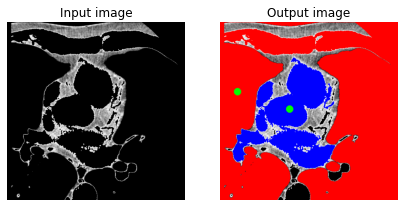

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
ax[0].imshow(img)
ax[0].set_title("Input image")
ax[0].axis('off')

ax[1].imshow(flood)
ax[1].set_title("Output image")
ax[1].axis('off')

plt.savefig('plots/region_growing.png', facecolor='white')
plt.show()

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1

# --- Load the sequence
image0 = img.copy()
image1 = cv.imread('dataset_pericardium_manual/input/ACel/013.png')

# --- Convert the images to gray level: color is not supported.
image0 = rgb2gray(image0)
image1 = rgb2gray(image1)

# --- Compute the optical flow
v, u = optical_flow_tvl1(image0, image1)

# --- Use the estimated optical flow for registration

nr, nc = image0.shape

row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')

image1_warp = warp(image1, np.array([row_coords + v, col_coords + u]),
                   mode='nearest')

# build an RGB image with the unregistered sequence
seq_im = np.zeros((nr, nc, 3))
seq_im[..., 0] = image0
seq_im[..., 1] = image1

# build an RGB image with the registered sequence
reg_im = np.zeros((nr, nc, 3))
reg_im[..., 0] = image0
reg_im[..., 1] = image1_warp

# build an RGB image with the registered sequence
target_im = np.zeros((nr, nc, 3))
target_im[..., 0] = image0
target_im[..., 1] = image0
target_im[..., 2] = image0

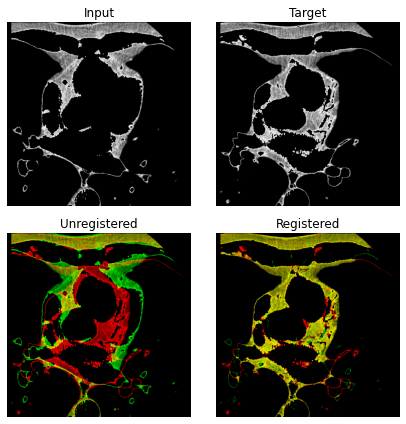

In [21]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(6, 6))

ax0.imshow(image1, cmap="gray")
ax0.set_title("Input")
ax0.set_axis_off()

ax1.imshow(target_im)
ax1.set_title("Target")
ax1.set_axis_off()

ax2.imshow(seq_im)
ax2.set_title("Unregistered")
ax2.set_axis_off()

ax3.imshow(reg_im)
ax3.set_title("Registered")
ax3.set_axis_off()

fig.tight_layout()
plt.savefig('plots/atlas_based.png', facecolor='white')
plt.show()

/Users/marinbenc/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/marinbenc/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/marinbenc/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/marinbenc/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


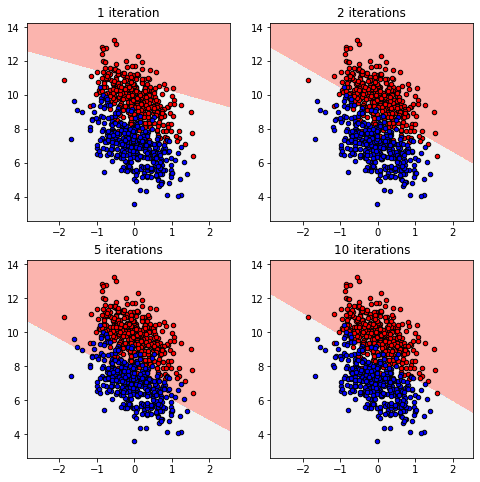

In [152]:
# Authors: Tom Dupre la Tour <tom.dupre-la-tour@m4x.org>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

centers = [[7, 7], [5, 5]]
X, y = make_blobs(n_samples=750, centers=centers, random_state=10)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

multi_class = 'multinomial'

iterations_count = 4

fig, axes = plt.subplots(2, 2, figsize=(8,8))
axes = axes.flatten()

for i, (iterations, ax) in enumerate(zip((1, 2, 5, 10), axes)):
    clf = LogisticRegression(solver='sag', max_iter=iterations, random_state=42,
                             multi_class=multi_class).fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
    ax.set_title(f'{iterations} {"iterations" if iterations > 1 else "iteration"}')

    # Plot also the training points
    colors = "rb"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        ax.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        ax.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    #for i, color in zip(clf.classes_ - 1, colors):
        #plot_hyperplane(i, color)

plt.savefig('plots/ml_training.png')

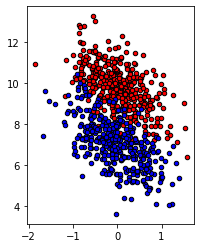

In [159]:
plt.figure(figsize=(3,4))
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                edgecolor='black', s=20)
plt.savefig('plots/ml_features.png')
plt.show()